In [27]:
import numpy as np
from mec_sandia.stopping_power import compute_stopping_power
import matplotlib.pyplot as plt

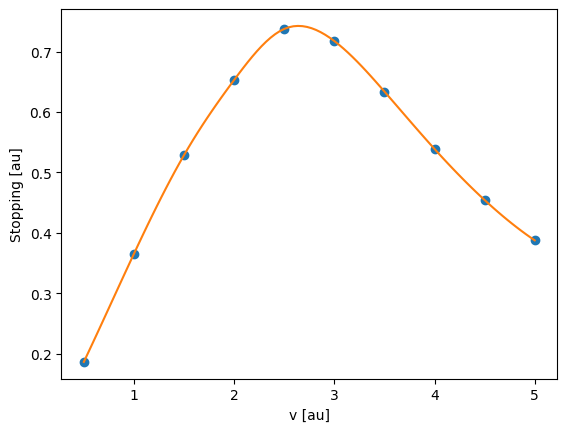

In [28]:
# Get DFT data
qData1 = np.loadtxt("AndrewsFirstGaussian/4.0_work_vs_dist")
position_au = qData1[:, 0] / (
    0.529
)  # divide the positions (angstroms) by the number of angstroms per atomic unit
time_au = (
    position_au / 4.0
)  # divide the positions in atomic units by the velocity in atomic units to get the time in atomic units
work_au = (
    qData1[:, 1] / 27.2
)  # divide the work in eV by the number of eV per atomic unit of energy

# load the full stopping curve
qData2 = np.loadtxt("AndrewsFirstGaussian/C_10gpcc_1eV_stopping_config1.txt")
velocity_au = qData2[:, 0]  # the velocities are already given in atomic units
stopping_au = qData2[:, 1] * (
    0.529 / 27.2
)  # the stopping powers are given in eV/A, so we multiply by the number of A/bohr and divide by the number of eV/Ha
plt.plot(velocity_au, stopping_au, marker="o", lw=0)
plt.xlabel("v [au]")
plt.ylabel("Stopping [au]")
from scipy.interpolate import CubicSpline

stopping_spl = CubicSpline(velocity_au, stopping_au)
xs = np.linspace(velocity_au[0], velocity_au[-1], 100)
plt.plot(xs, stopping_spl(xs), label="cubic spline")

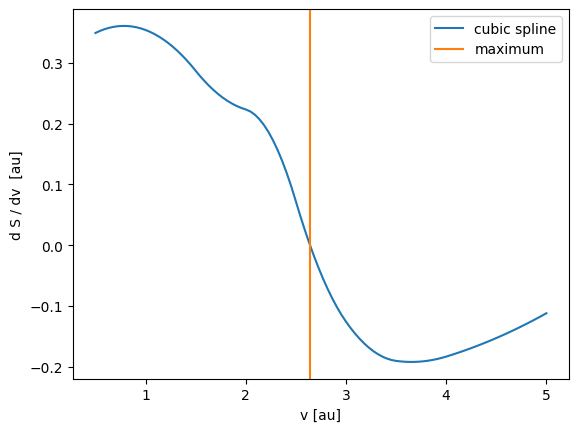

In [29]:
stopping_deriv_spl = stopping_spl.derivative(1)
import scipy.optimize

max_vel = scipy.optimize.bisect(stopping_deriv_spl, velocity_au[0], velocity_au[-1])
plt.plot(xs, stopping_deriv_spl(xs), label="cubic spline")
plt.xlabel("v [au]")
plt.axvline(max_vel, label="maximum", color="C1")
plt.ylabel("d S / dv  [au]")
plt.legend()

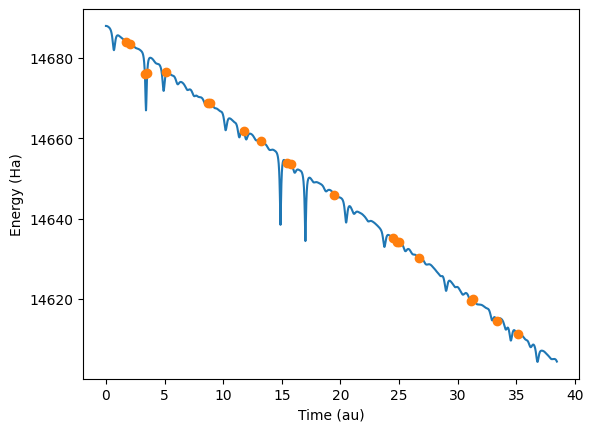

In [30]:
# Look at a single velocity first
v_proj = 4.0  # atomic units just taken from carbon
mass_proj = 1836
ke_proj = 0.5 * mass_proj * v_proj**2.0  # classical ke
ke_time = 0.5 * mass_proj * (v_proj**2) - work_au
velocity_time = np.sqrt(2.0 / mass_proj * ke_time)  # 1/2 mv^2 = KE, so sqrt(2/m*KE)=v
kproj_time = mass_proj * velocity_time
k0 = (2 * mass_proj * ke_proj) ** 0.5
plt.plot(time_au, ke_time)
plt.xlabel("Time (au)")
plt.ylabel("Energy (Ha)")

# Worry about point selection later
np.random.seed(7)
sub_sample = np.random.choice(np.arange(len(time_au)), 20)
plt.plot(time_au[sub_sample], ke_time[sub_sample], marker="o", lw=0)

In [31]:
# Let's read in the Carbon example provided by Sandia
import numpy as np
from mec_sandia.vasp_utils import read_vasp

ase_cell = read_vasp(f"../vasp_data/C_POSCAR")
# Next we can get some system paramters
volume_ang = ase_cell.get_volume()
print("Volume = {} A^3".format(volume_ang))

# To compute rs parameter we need volume in Bohr
from ase.units import Bohr

volume_bohr = volume_ang / Bohr**3
# and the number of valence electrons
num_carbon = len(np.where(ase_cell.get_atomic_numbers() == 6)[0])
# There is 1 hydrogen atom in the cell
num_elec = 1 + num_carbon * 4
from mec_sandia.vasp_utils import compute_wigner_seitz_radius

# Get the Wigner-Seitz radius
rs = compute_wigner_seitz_radius(volume_bohr, num_elec)
print("rs = {} bohr".format(rs))

Volume = 255.27133939199965 A^3
rs = 0.9289611708818379 bohr


In [32]:
from matplotlib.pyplot import box
from mec_sandia.stopping_power import compute_stopping_power
from ase.units import Hartree

# First look at stopping power

ecut_ha = 2000 / Hartree
# pretend it's cubic
box_length = volume_bohr ** (1.0 / 3.0)
# wavepacket variance in k-space
sigma_k = 4
time_vals = time_au[sub_sample]
ix = np.argsort(time_vals)
time_vals = time_vals[ix]
kproj_x_vals = kproj_time[sub_sample][ix]
kproj_vals = np.array([np.array([kx, 0, 0]) for kx in kproj_x_vals])
stopping_deriv = np.abs(stopping_deriv_spl(v_proj))
stopping_data = compute_stopping_power(
    ecut_ha,
    box_length,
    sigma_k,
    time_vals,
    kproj_vals,
    stopping_deriv,
    mass_proj,
    num_samples=100,
)
print(stopping_data.stopping)

-0.5351089352461363


[]

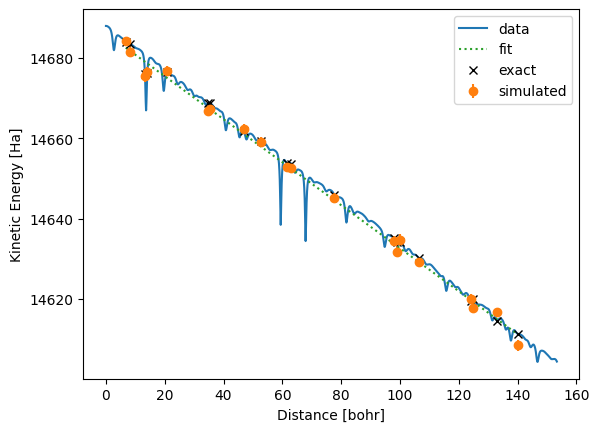

In [33]:
# look at the kinetic energy data
distance = time_au * velocity_time
plt.plot(distance, ke_time, label="data")
plt.errorbar(
    stopping_data.distance,
    stopping_data.kinetic,
    stopping_data.kinetic_err,
    fmt="o",
    label="simulated",
)
plt.plot(
    stopping_data.distance,
    stopping_data.linear_fit(stopping_data.distance),
    ls=":",
    label="fit",
)
plt.plot(
    stopping_data.distance,
    kproj_x_vals**2.0 / (2 * mass_proj),
    marker="x",
    label="exact",
    lw=0,
    color="black",
)
plt.legend()
plt.xlabel("Distance [bohr]")
plt.ylabel("Kinetic Energy [Ha]")
plt.plot()

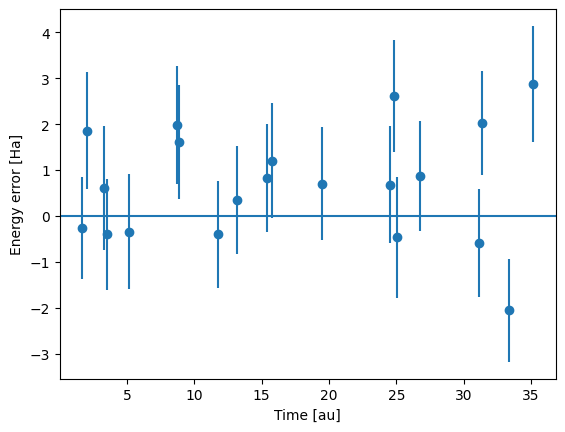

In [34]:
# look at expected vs simulated kinetic energy error
plt.errorbar(
    stopping_data.time_vals,
    np.sum(kproj_vals**2.0, axis=-1) / (2 * mass_proj) - stopping_data.kinetic,
    stopping_data.kinetic_err,
    fmt="o",
)
plt.xlabel("Time [au]")
plt.ylabel("Energy error [Ha]")
plt.axhline(0)

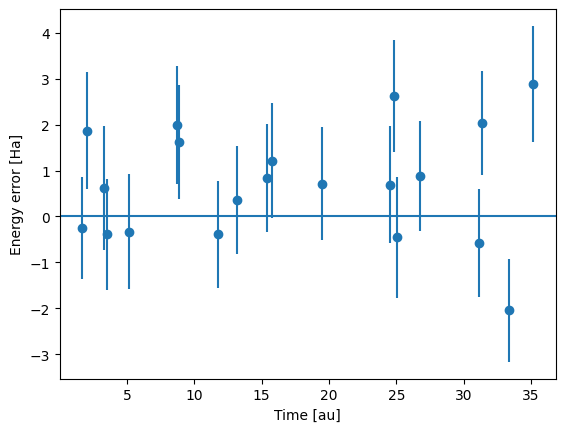

In [35]:
# include variance term in "exact projectile ke"
ke_exact = (
    np.sum(kproj_vals**2.0, axis=-1) + 3 * stopping_data.sigma_vals**2.0
) / (2 * mass_proj)
plt.errorbar(
    stopping_data.time_vals,
    ke_exact - stopping_data.kinetic,
    stopping_data.kinetic_err,
    fmt="o",
)
plt.xlabel("Time [au]")
plt.ylabel("Energy error [Ha]")
plt.axhline(0)

expected_stopping = -0.5321931772498634
value from file = 0.5388580705882354


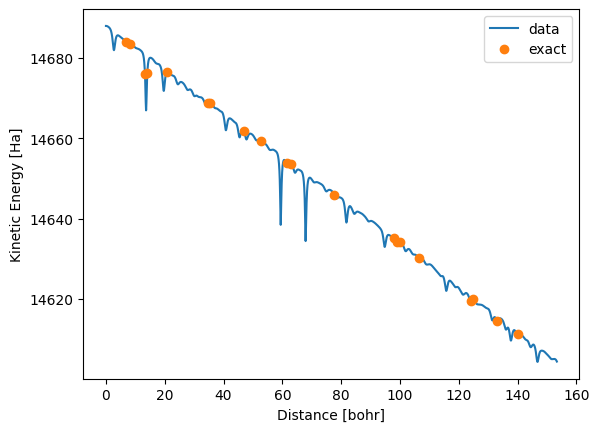

In [36]:
# Find "exact" stopping power from DFT data
distance = time_au * velocity_time
plt.plot(distance, ke_time, label="data")
plt.plot(
    stopping_data.distance,
    kproj_x_vals**2.0 / (2 * mass_proj),
    marker="o",
    label="exact",
    lw=0,
)
plt.legend()
plt.xlabel("Distance [bohr]")
plt.ylabel("Kinetic Energy [Ha]")
plt.plot()


def _fit_linear(x, a, b):
    return a * x + b


yvals = kproj_x_vals**2.0 / (2 * mass_proj)
popt, pcov = scipy.optimize.curve_fit(
    _fit_linear,
    stopping_data.distance,
    yvals,
)
expected_val = popt[0]
print(f"expected_stopping = {expected_val}")
print(f"value from file = {stopping_spl(4.0)}")

In [37]:
# Monitor convergence with sampling amount
results = []
num_samples = np.logspace(1, 5, 8)
for ns in num_samples:
    results.append(
        compute_stopping_power(
            ecut_ha,
            box_length,
            sigma_k,
            time_vals,
            kproj_vals,
            stopping_deriv,
            mass_proj,
            num_samples=int(ns),
        )
    )

Text(0, 0.5, 'Stopping Power [au]')

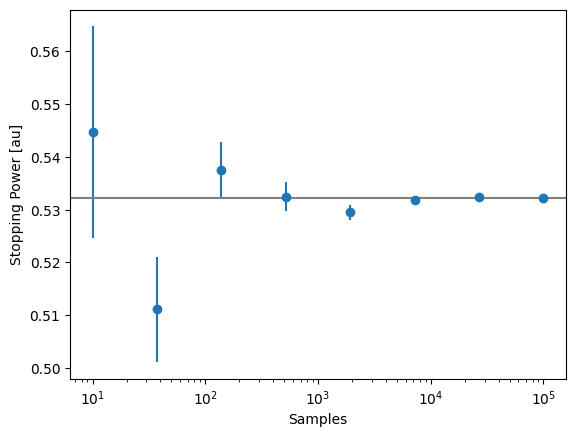

In [38]:
means = [r.stopping for r in results]
errs = [r.stopping_err for r in results]
plt.errorbar(num_samples, np.abs(means), yerr=errs, fmt="o")
plt.axhline(np.abs(expected_val), color="grey")
plt.xlabel("Samples")
plt.xscale("log")
plt.ylabel("Stopping Power [au]")

In [39]:
num_samples = 1_000
sim_res = []
act_res = []
qData2 = np.loadtxt("AndrewsFirstGaussian/C_10gpcc_1eV_stopping_config1.txt")
velocity_au = qData2[:, 0]  # the velocities are already given in atomic units

from mec_sandia.stopping_power import parse_stopping_data

for vel in velocity_au:
    dft_data = parse_stopping_data(
        f"AndrewsFirstGaussian/{vel}_work_vs_dist", vel, mass_proj=mass_proj, num_points=20
    )
    stopping_deriv = np.abs(stopping_deriv_spl(vel))
    kproj_vals = np.array([np.array([kx, 0, 0]) for kx in dft_data.kproj_sub_sample])
    stopping_data = compute_stopping_power(
        ecut_ha,
        box_length,
        sigma_k,
        dft_data.time_sub_sample,
        kproj_vals,
        stopping_deriv,
        mass_proj,
        num_samples=num_samples,
    )
    sim_res.append(stopping_data)
    yvals = dft_data.kproj_sub_sample**2.0 / (2 * mass_proj)
    popt, pcov = scipy.optimize.curve_fit(
        _fit_linear,
        stopping_data.distance,
        yvals,
    )
    expected_val = popt[0]
    act_res.append(abs(expected_val))

Text(0, 0.5, 'Stopping Power [au]')

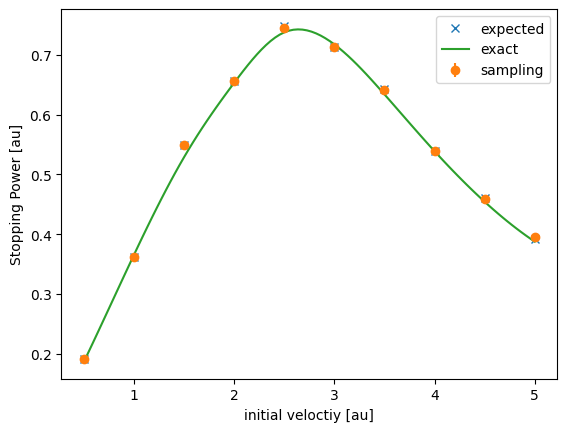

In [40]:
plt.plot(velocity_au, act_res, label="expected", lw=0, marker="x")
vals = [abs(s.stopping) for s in sim_res]
errs = [s.stopping_err for s in sim_res]
plt.errorbar(velocity_au, vals, yerr=errs, fmt="o", label="sampling")
xs = np.linspace(velocity_au[0], velocity_au[-1], 100)
plt.plot(xs, stopping_spl(xs), label="exact")
plt.legend()
plt.xlabel("initial veloctiy [au]")
plt.ylabel("Stopping Power [au]")

Text(0, 0.5, 'Stopping Power error [au]')

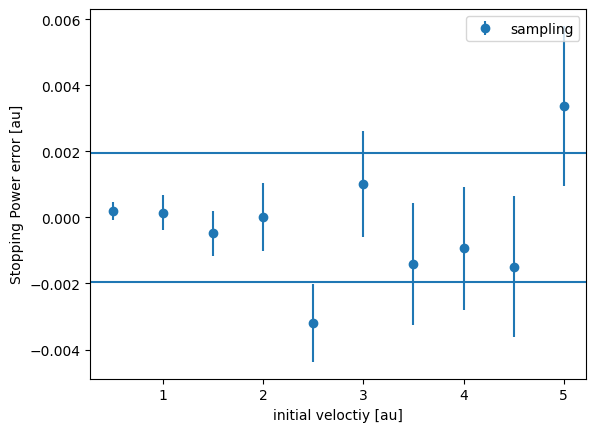

In [41]:
vals = [abs(s.stopping) for s in sim_res]
errs = [s.stopping_err for s in sim_res]
plt.errorbar(velocity_au, np.array(vals) - np.array(act_res), yerr=errs, fmt="o", label="sampling")
# plt.plot(velocity_au, act_res, label="expected", lw=0, marker="x")
plt.legend()
from ase.units import Hartree, Bohr
stopping_err = 0.1 # eV/A
stopping_err_au = stopping_err * Bohr / Hartree
plt.axhline(stopping_err_au)
plt.axhline(-stopping_err_au)
plt.xlabel("initial veloctiy [au]")
plt.ylabel("Stopping Power error [au]")

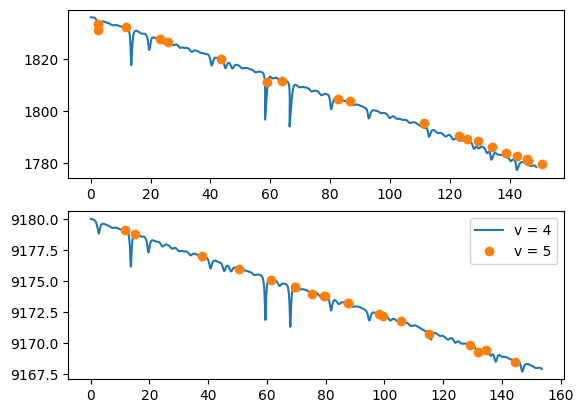

In [42]:
from mec_sandia.stopping_power import parse_stopping_data
data_1 = parse_stopping_data(
    f"AndrewsFirstGaussian/{1.0}_work_vs_dist", 1.0
)
data_5 = parse_stopping_data(
    f"AndrewsFirstGaussian/{5.0}_work_vs_dist", 5.0 
)
fig, ax = plt.subplots(2,1)
ax[0].plot(data_1.distance, data_1.kproj, label="v = 1")
ax[0].plot(data_1.time_sub_sample, data_1.kproj_sub_sample, label="v = 1", marker="o", lw=0)
ax[1].plot(data_5.distance, data_5.kproj, label="v = 4")
ax[1].plot(5*data_5.time_sub_sample, data_5.kproj_sub_sample, label="v = 5", marker="o", lw=0)
plt.legend()

## Check minimum number of samples for given error thresholds and sigma

Text(0, 0.5, 'Stopping Power error [au]')

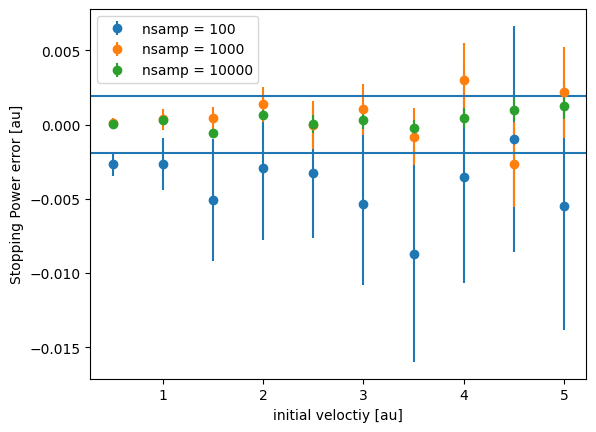

In [43]:
sim_res = []
act_res = []
qData2 = np.loadtxt("AndrewsFirstGaussian/C_10gpcc_1eV_stopping_config1.txt")
velocity_au = qData2[:, 0]  # the velocities are already given in atomic units

from mec_sandia.stopping_power import parse_stopping_data
from ase.units import Bohr, Hartree

stopping_err = 0.1 # eV/A
stopping_err_au = stopping_err * Bohr / Hartree
sigma_k = 10

for num_samples in [100, 1_000, 10_000]:
    sim_res = []
    act_res = []
    for vel in velocity_au:
        dft_data = parse_stopping_data(
            f"AndrewsFirstGaussian/{vel}_work_vs_dist", vel, mass_proj=mass_proj, num_points=20
        )
        stopping_deriv = np.abs(stopping_deriv_spl(vel))
        kproj_vals = np.array([np.array([kx, 0, 0]) for kx in dft_data.kproj_sub_sample])
        stopping_data = compute_stopping_power(
            ecut_ha,
            box_length,
            sigma_k,
            dft_data.time_sub_sample,
            kproj_vals,
            stopping_deriv,
            mass_proj,
            num_samples=num_samples,
        )
        sim_res.append(stopping_data)
        yvals = dft_data.kproj_sub_sample**2.0 / (2 * mass_proj)
        popt, pcov = scipy.optimize.curve_fit(
            _fit_linear,
            stopping_data.distance,
            yvals,
        )
        expected_val = popt[0]
        act_res.append(abs(expected_val))
    vals = [abs(s.stopping) for s in sim_res]
    errs = [s.stopping_err for s in sim_res]
    plt.errorbar(velocity_au, np.array(vals) - np.array(act_res), yerr=errs, fmt="o", label=f"nsamp = {num_samples}")
    plt.legend()
plt.axhline(stopping_err_au)
plt.axhline(-stopping_err_au)
plt.xlabel("initial veloctiy [au]")
plt.ylabel("Stopping Power error [au]")

## Check Convergence

In [44]:
# Get DFT data
vel = 0.5
qData1 = np.loadtxt(f"AndrewsFirstGaussian/{vel}_work_vs_dist")
position_au = qData1[:, 0] / (
    0.529
)  # divide the positions (angstroms) by the number of angstroms per atomic unit
time_au = (
    position_au / vel
)  # divide the positions in atomic units by the velocity in atomic units to get the time in atomic units
work_au = (
    qData1[:, 1] / 27.2
)  # divide the work in eV by the number of eV per atomic unit of energy

0.0019446903957408628


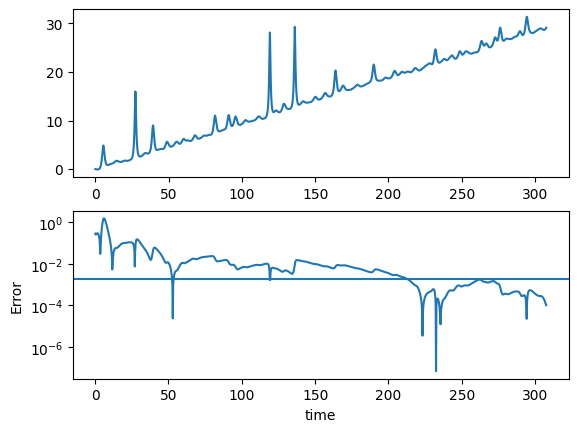

In [45]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(time_au, work_au)
times = []
results = []
stopping_spl(vel)
ke_time = 0.5 * mass_proj * (v_proj**2) - work_au
velocity_time = np.sqrt(2.0 / mass_proj * ke_time)  # 1/2 mv^2 = KE, so sqrt(2/m*KE)=v
for time_slice in range(10, len(time_au), 20):
    popt, pcov = scipy.optimize.curve_fit(
        # _fit_linear, velocity_time[:time_slice]*time_au[:time_slice], work_au[:time_slice],
        _fit_linear,
        vel * time_au[:time_slice],
        work_au[:time_slice],
    )
    times.append(time_au[:time_slice][-1])
    results.append(popt[0])
from ase.units import Hartree, Bohr
stopping_err = 0.1 # eV/A
stopping_err_au = stopping_err * Bohr / Hartree
print(stopping_err_au)
ax[1].plot(times, abs(stopping_spl(vel) - np.array(results)))
ax[1].axhline(stopping_err_au)
ax[1].set_xlabel("time")
ax[1].set_ylabel("Error")
ax[1].set_yscale("log")

# Cross-check with Electrons

Volume = 255.27133939199965 A^3
rs = 0.9289611708818379 bohr
box_length = 11.987617756468008 bohr
Generating stopping data from scratch.
vel = 0.5, ns = 1000
Generating stopping data from scratch.
vel = 1.0, ns = 1000
Generating stopping data from scratch.
vel = 1.5, ns = 1000
Generating stopping data from scratch.
vel = 2.0, ns = 1000
Generating stopping data from scratch.
vel = 2.5, ns = 1000
Generating stopping data from scratch.
vel = 3.0, ns = 1000
Generating stopping data from scratch.
vel = 3.5, ns = 1000
Generating stopping data from scratch.
vel = 4.0, ns = 1000
Generating stopping data from scratch.
vel = 4.5, ns = 1000
Generating stopping data from scratch.
vel = 5.0, ns = 1000


<ErrorbarContainer object of 3 artists>

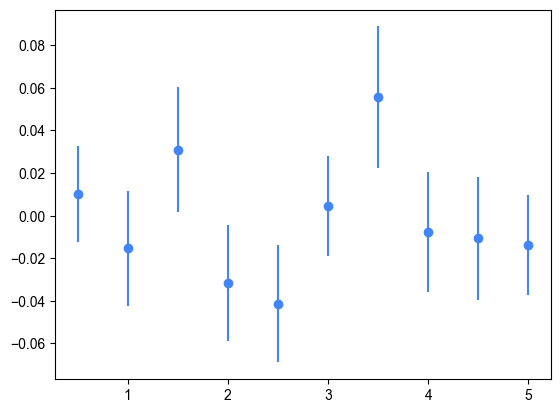

In [16]:
from ase.units import Bohr, Hartree
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline

from mec_sandia.stopping_power import (
    compute_stopping_power_electrons,
    parse_stopping_data,
)
from mec_sandia.vasp_utils import compute_wigner_seitz_radius
from mec_sandia.vasp_utils import read_kohn_sham_data
from mec_sandia.vasp_utils import read_vasp

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "arial"

colors = ["#4285f4", "#ea4335", "#fbbc04", "#34a853"]


qData2 = np.loadtxt("AndrewsFirstGaussian/C_10gpcc_1eV_stopping_config1.txt")
velocity_au = qData2[:, 0]  # the velocities are already given in atomic units
stopping_au = qData2[:, 1] * (
    Bohr / Hartree
)  # the stopping powers are given in eV/A, so we multiply by the number of A/bohr and divide by the number of eV/Ha

stopping_spl = CubicSpline(velocity_au, stopping_au)
xs = np.linspace(velocity_au[0], velocity_au[-1], 100)
stopping_deriv_spl = stopping_spl.derivative(1)

stopping_err = 0.1  # eV/A
stopping_err_au = stopping_err * Bohr / Hartree
sigma_k = 10
mass_proj = 1836

ase_cell = read_vasp(f"../vasp_data/C_POSCAR")
# Next we can get some system paramters
volume_ang = ase_cell.get_volume()
print("Volume = {} A^3".format(volume_ang))

# To compute rs parameter we need volume in Bohr
from ase.units import Bohr

volume_bohr = volume_ang / Bohr**3
# and the number of valence electrons
num_carbon = len(np.where(ase_cell.get_atomic_numbers() == 6)[0])
# There is 1 hydrogen atom in the cell
num_elec = 1 + num_carbon * 4

# Get the Wigner-Seitz radius
rs = compute_wigner_seitz_radius(volume_bohr, num_elec)
print("rs = {} bohr".format(rs))

ecut_ha = 2000
box_length = volume_bohr ** (1.0 / 3.0)
print("box_length = {} bohr".format(box_length))

# Thermal data
eigs_1ev, occs_1ev = read_kohn_sham_data("../vasp_data/C_1eV_EIGENVAL")
np.random.seed(7)

sim_res = []
errs = []

num_samples = 1_000

act_res = []
errs = []
for vel in velocity_au:
    dft_data = parse_stopping_data(
        f"AndrewsFirstGaussian/{vel}_work_vs_dist",
        vel,
        mass_proj=mass_proj,
        num_points=20,
    )
    stopping_deriv = np.abs(stopping_deriv_spl(vel))
    kproj_vals = np.array(
        [np.array([kx, 0, 0]) for kx in dft_data.kproj_sub_sample]
    )
    print("Generating stopping data from scratch.")
    print(f"vel = {vel}, ns = {num_samples}")
    stopping_data = compute_stopping_power_electrons(
        eigs_1ev,
        occs_1ev,
        sigma_k,
        dft_data.time_sub_sample,
        kproj_vals,
        stopping_deriv,
        mass_proj,
        num_samples=num_samples,
    )
    sim_res.append(stopping_data)
    act_res.append(abs(stopping_data.stopping_expected))
    vals = [abs(s.stopping) for s in sim_res]
    errs = [s.stopping_err for s in sim_res]
#plt.errorbar(stopping_data.time_vals, stopping_data.kinetic, yerr=stopping_data.kinetic_err, fmt='o')
plt.errorbar(
    velocity_au,
    np.array(vals) - np.array(act_res),
    yerr=errs,
    fmt="o",
    color=colors[0],
    label=r"$N_s$ = {:d}".format(num_samples),
)


# Remove rare events

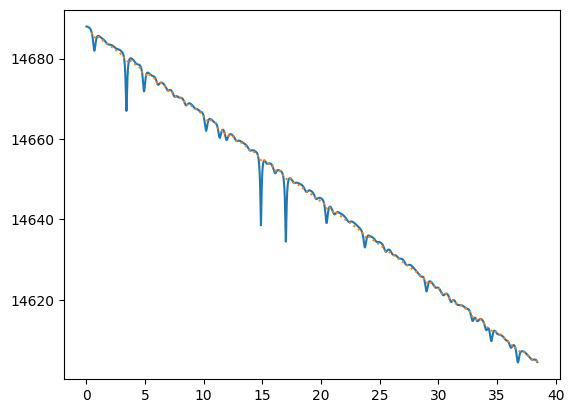

In [2]:
# Look at a single velocity first
import matplotlib.pyplot as plt
vel = 4.0  # atomic units just taken from carbon
from mec_sandia.stopping_power import (
    parse_stopping_data,
)
stopping_data = "AndrewsFirstGaussian/C_10gpcc_1eV_stopping_config1.txt"
data = parse_stopping_data(
        f"AndrewsFirstGaussian/{vel}_work_vs_dist",
        vel,
        num_points=20,
        stopping_data_filename=stopping_data,
    )
plt.plot(data.times, data.kinetic)
data = parse_stopping_data(
        f"AndrewsFirstGaussian/{vel}_work_vs_dist",
        vel,
        num_points=20,
        rare_event=0.5,
        stopping_data_filename=stopping_data,
    )
plt.plot(data.times, data.kinetic, ls=":")

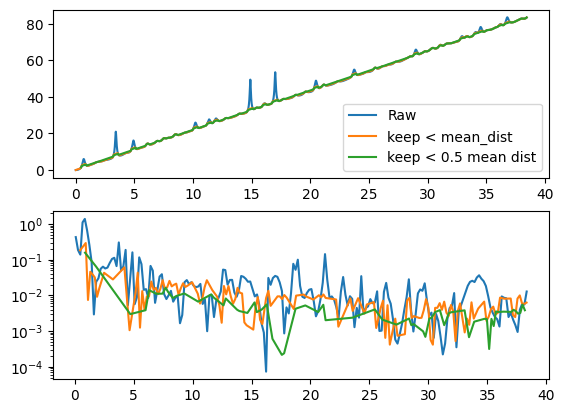

In [3]:
data = parse_stopping_data(
        f"AndrewsFirstGaussian/{vel}_work_vs_dist",
        vel,
        num_points=20,
        stopping_data_filename=stopping_data,
    )
from mec_sandia.stopping_power import compute_stopping_exact
errs = []
times = []
time_windows = range(10, len(data.times), 20)
fig, ax = plt.subplots(2,1)
for time_slice in time_windows:
    skip = len(data.distance[:time_slice]) // 10
    xvals = data.distance[:time_slice][::skip]
    yvals = data.work[:time_slice][::skip]
    stopping = compute_stopping_exact(xvals, yvals)
    errs.append(abs(stopping - data.stopping))
    times.append(data.times[:time_slice][-1])

ax[1].plot(times, errs)
ax[0].plot(data.times, data.work, label="Raw")
data = parse_stopping_data(
        f"AndrewsFirstGaussian/{vel}_work_vs_dist",
        vel,
        num_points=20,
        stopping_data_filename=stopping_data,
        rare_event=1,
    )
time_windows = range(10, len(data.times), 20)
errs = []
times = []
for time_slice in time_windows:
    skip = len(data.distance[:time_slice]) // 10
    xvals = data.distance[:time_slice][::skip]
    yvals = data.work[:time_slice][::skip]
    stopping = compute_stopping_exact(xvals, yvals)
    errs.append(abs(stopping - data.stopping))
    times.append(data.times[:time_slice][-1])
ax[0].plot(data.times, data.work, label="keep < mean_dist")
ax[1].plot(times, errs, label="discared 1 x mean")
data = parse_stopping_data(
        f"AndrewsFirstGaussian/{vel}_work_vs_dist",
        vel,
        num_points=20,
        stopping_data_filename=stopping_data,
        rare_event=0.5,
    )
time_windows = range(10, len(data.times), 20)
errs = []
times = []
for time_slice in time_windows:
    skip = len(data.distance[:time_slice]) // 10
    xvals = data.distance[:time_slice][::skip]
    yvals = data.work[:time_slice][::skip]
    stopping = compute_stopping_exact(xvals, yvals)
    errs.append(abs(stopping - data.stopping))
    times.append(data.times[:time_slice][-1])
ax[0].plot(data.times, data.work, label="keep < 0.5 mean dist")
ax[1].plot(times, errs, label="discared 0.5 x mean")
ax[0].legend()
ax[1].set_yscale("log")

Text(0, 0.5, '$\\sqrt{SS}$')

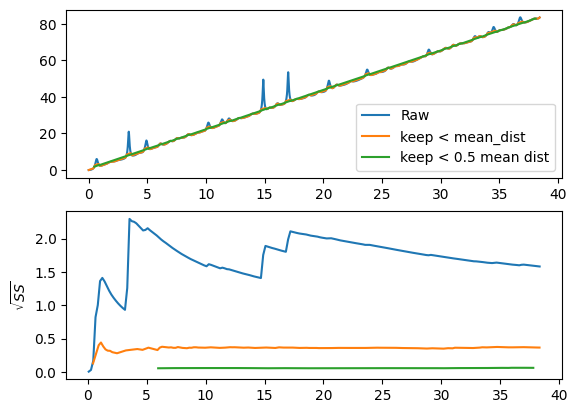

In [7]:
import numpy as np
data = parse_stopping_data(
        f"AndrewsFirstGaussian/{vel}_work_vs_dist",
        vel,
        num_points=20,
        stopping_data_filename=stopping_data,
    )
from mec_sandia.stopping_power import fit_linear_stats 
errs = []
times = []
time_windows = range(10, len(data.times), 20)
fig, ax = plt.subplots(2,1)
for time_slice in time_windows:
    xvals = data.distance[:time_slice]
    yvals = data.work[:time_slice]
    stopping = fit_linear_stats(xvals, yvals)
    errs.append(np.sqrt(stopping.ss_res/len(xvals)))
    times.append(data.times[:time_slice][-1])

ax[1].plot(times, errs)
ax[0].plot(data.times, data.work, label="Raw")
data = parse_stopping_data(
        f"AndrewsFirstGaussian/{vel}_work_vs_dist",
        vel,
        num_points=20,
        stopping_data_filename=stopping_data,
        rare_event=1,
    )
time_windows = range(10, len(data.times), 20)
errs = []
times = []
for time_slice in time_windows:
    xvals = data.distance[:time_slice]
    yvals = data.work[:time_slice]
    stopping = fit_linear_stats(xvals, yvals)
    errs.append(np.sqrt(stopping.ss_res/len(xvals)))
    times.append(data.times[:time_slice][-1])

ax[0].plot(data.times, data.work, label="keep < mean_dist")
ax[1].plot(times, errs, label="discared 1 x mean")
data = parse_stopping_data(
        f"AndrewsFirstGaussian/{vel}_work_vs_dist",
        vel,
        num_points=20,
        stopping_data_filename=stopping_data,
        rare_event=0.125,
    )
time_windows = range(10, len(data.times), 20)
errs = []
times = []
for time_slice in time_windows:
    xvals = data.distance[:time_slice]
    yvals = data.work[:time_slice]
    stopping = fit_linear_stats(xvals, yvals)
    errs.append(np.sqrt(stopping.ss_res/len(xvals)))
    times.append(data.times[:time_slice][-1])

ax[0].plot(data.times, data.work, label="keep < 0.125 mean dist")
ax[1].plot(times, errs, label="discared 0.125 x mean")
ax[0].legend()
ax[1].set_ylabel("$\sqrt{SS}$")

0.5 7 21 304.14639141704725 7.22815459123608
1.0 5 10 152.27824973948066 3.588445541748408
1.5 5 10 101.5914564622844 9.650355331916254
2.0 6 6 76.24165188521886 9.45811717789402
2.5 7 14 61.008700560496855 9.965625904512722
3.0 8 30 50.78932029267478 9.855409362873305
3.5 10 59 43.54468814537965 9.864563560683887
4.0 10 49 38.10160212720721 9.99638400915628
4.5 10 56 33.87663469769628 9.936576583460472
5.0 10 64 30.47359217560487 9.719561067364257


(0.0, 1.0)

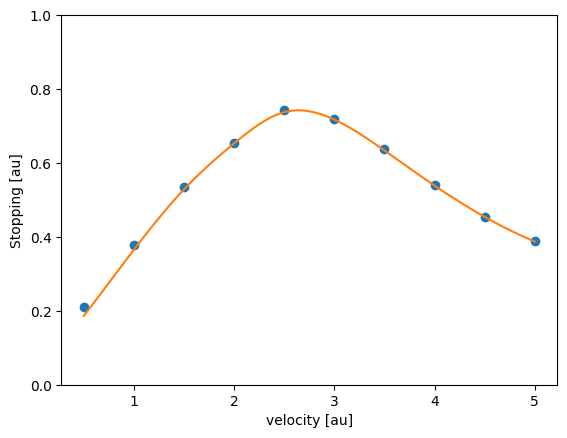

In [18]:
import numpy as np
from scipy.interpolate import CubicSpline
qData2 = np.loadtxt("AndrewsFirstGaussian/C_10gpcc_1eV_stopping_config1.txt")
velocity_au = qData2[:, 0]  # the velocities are already given in atomic units
max_time = 10.0 # au
stopping_approx = []
stopping_exact = []
num_pts_fit = 10
for vel in velocity_au:
    data = parse_stopping_data(
            f"AndrewsFirstGaussian/{vel}_work_vs_dist",
            vel,
            num_points=10,
            stopping_data_filename=stopping_data,
            rare_event=0.125,
        )
    max_time_indx = np.where(data.times < max_time)[0][-1]
    time_slice = len(data.times[:max_time_indx]) // num_pts_fit + 1
    xvals = data.distance[:max_time_indx][::time_slice]
    yvals = data.work[:max_time_indx][::time_slice]
    print(vel, len(xvals), max_time_indx, max(data.times), data.times[max_time_indx])
    stopping_approx.append(fit_linear_stats(xvals, yvals).slope)
    stopping_exact.append(data.stopping)

plt.plot(velocity_au, stopping_approx, label="computed", marker='o', lw=0)
stopping_spl = CubicSpline(velocity_au, stopping_exact)
xs = np.linspace(velocity_au[0], velocity_au[-1], 100)
plt.plot(xs, stopping_spl(xs), label="cubic spline")
plt.xlabel("velocity [au]")
plt.ylabel("Stopping [au]")
plt.ylim([0, 1])

Text(0, 0.5, 'Stopping [au]')

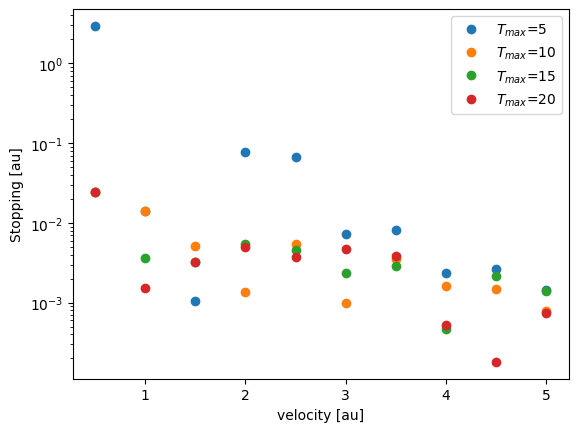

In [25]:
import numpy as np
from scipy.interpolate import CubicSpline
qData2 = np.loadtxt("AndrewsFirstGaussian/C_10gpcc_1eV_stopping_config1.txt")
velocity_au = qData2[:, 0]  # the velocities are already given in atomic units
num_pts_fit = 10
for max_time in [5, 10, 15, 20]:
    stopping_approx = []
    stopping_exact = []
    for vel in velocity_au:
        data = parse_stopping_data(
                f"AndrewsFirstGaussian/{vel}_work_vs_dist",
                vel,
                num_points=10,
                stopping_data_filename=stopping_data,
                rare_event=.125,
            )
        max_time_indx = np.where(data.times < max_time)[0][-1]
        time_slice = len(data.times[:max_time_indx]) // num_pts_fit + 1
        xvals = data.distance[:max_time_indx][::time_slice]
        yvals = data.work[:max_time_indx][::time_slice]
        stopping_approx.append(fit_linear_stats(xvals, yvals).slope)
        stopping_exact.append(data.stopping)
    xs = np.linspace(velocity_au[0], velocity_au[-1], 100)
    stopping_spl = CubicSpline(velocity_au, stopping_exact)
    plt.plot(velocity_au, np.abs(stopping_spl(velocity_au)-np.array(stopping_approx)), label=f"$T_{{max}}$={max_time}", marker='o', lw=0)
    #plt.plot(velocity_au, np.array(stopping_approx), label=f"$T_{{max}}$={max_time}", marker='o', lw=0)
#plt.plot(xs, stopping_spl(xs), label="cubic spline")
plt.legend()
plt.yscale("log")
plt.xlabel("velocity [au]")
plt.ylabel("Stopping [au]")
#plt.ylim([0, 1])

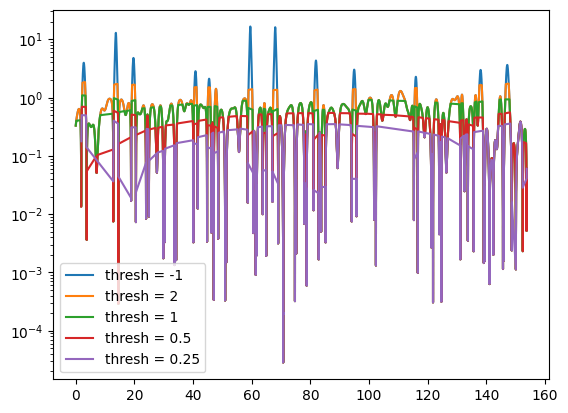

In [35]:
# Look at fluctuations with time
vel = 1.0
data = parse_stopping_data(
        f"AndrewsFirstGaussian/{vel}_work_vs_dist",
        vel,
        num_points=10,
        stopping_data_filename=stopping_data,
        rare_event=.125,
    )
num_pts = 10
time_slice = len(data.distance) // num_pts + 1
xvals = data.distance[::time_slice]
yvals = data.work[::time_slice]
stats = fit_linear_stats(xvals, yvals)
from mec_sandia.stopping_power import _fit_linear
for discard in [-1, 2, 1, 0.5, 0.25]:
    data = parse_stopping_data(
            f"AndrewsFirstGaussian/{vel}_work_vs_dist",
            vel,
            num_points=20,
            stopping_data_filename=stopping_data,
            rare_event=discard,
        )
    fx = _fit_linear(data.distance, *stats.popt)
    plt.plot(data.times, np.sqrt((data.work - fx)**2.0), label=f"thresh = {discard}")

plt.legend()
plt.yscale("log")



# Gaussian convergence Comparing time length and number of points 

Volume = 255.27133939199965 A^3
rs = 0.9289611708818379 bohr
box_length = 11.987617756468008 bohr


Text(0, 0.5, 'Stopping Power error [au]')

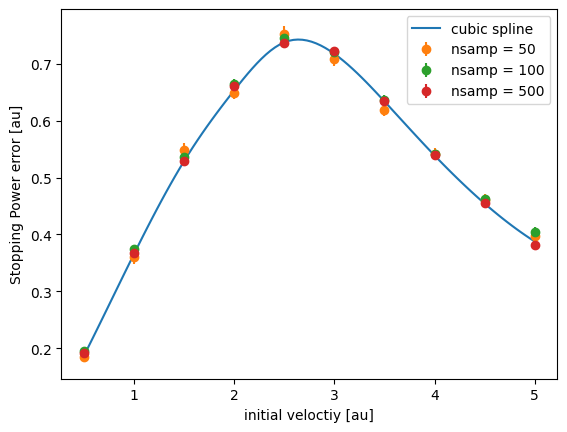

In [33]:
# Let's read in the Carbon example provided by Sandia
import numpy as np
from mec_sandia.vasp_utils import read_vasp
import matplotlib.pyplot as plt
import scipy.optimize

ase_cell = read_vasp(f"../vasp_data/C_POSCAR")
# Next we can get some system paramters
volume_ang = ase_cell.get_volume()
print("Volume = {} A^3".format(volume_ang))

# To compute rs parameter we need volume in Bohr
from ase.units import Bohr

volume_bohr = volume_ang / Bohr**3
# and the number of valence electrons
num_carbon = len(np.where(ase_cell.get_atomic_numbers() == 6)[0])
# There is 1 hydrogen atom in the cell
num_elec = 1 + num_carbon * 4
from mec_sandia.vasp_utils import compute_wigner_seitz_radius

# Get the Wigner-Seitz radius
rs = compute_wigner_seitz_radius(volume_bohr, num_elec)
print("rs = {} bohr".format(rs))
sim_res = []
act_res = []
qData2 = np.loadtxt("AndrewsFirstGaussian/C_10gpcc_1eV_stopping_config1.txt")
velocity_au = qData2[:, 0]  # the velocities are already given in atomic units

from mec_sandia.stopping_power import parse_stopping_data, compute_stopping_power, _fit_linear
from ase.units import Bohr, Hartree

stopping_err = 0.1  # eV/A
stopping_err_au = stopping_err * Bohr / Hartree
sigma_k = 10
# Get DFT data
qData1 = np.loadtxt("AndrewsFirstGaussian/4.0_work_vs_dist")
position_au = qData1[:, 0] / (
    0.529
)  # divide the positions (angstroms) by the number of angstroms per atomic unit
time_au = (
    position_au / 4.0
)  # divide the positions in atomic units by the velocity in atomic units to get the time in atomic units
work_au = (
    qData1[:, 1] / 27.2
)  # divide the work in eV by the number of eV per atomic unit of energy

# load the full stopping curve
qData2 = np.loadtxt("AndrewsFirstGaussian/C_10gpcc_1eV_stopping_config1.txt")
velocity_au = qData2[:, 0]  # the velocities are already given in atomic units
stopping_au = qData2[:, 1] * (
    0.529 / 27.2
)  # the stopping powers are given in eV/A, so we multiply by the number of A/bohr and divide by the number of eV/Ha
#plt.plot(velocity_au, stopping_au, marker="o", lw=0)
plt.xlabel("v [au]")
plt.ylabel("Stopping [au]")
from scipy.interpolate import CubicSpline

stopping_spl = CubicSpline(velocity_au, stopping_au)
xs = np.linspace(velocity_au[0], velocity_au[-1], 100)
plt.plot(xs, stopping_spl(xs), label="cubic spline")
stopping_deriv_spl = stopping_spl.derivative(1)

num_fit_pts = 10
max_time = 40.0
mass_proj = 1838
ecut_ha = 1000 / Hartree
sigma_k = 10.0
box_length = volume_bohr ** (1.0 / 3.0)
print("box_length = {} bohr".format(box_length))
for num_samples in [50, 100, 500]:
    sim_res = []
    act_res = []
    for vel in velocity_au:
        dft_data = parse_stopping_data(
            f"AndrewsFirstGaussian/{vel}_work_vs_dist",
            vel,
            mass_proj=mass_proj,
            num_points=num_fit_pts,
            rare_event=0.25,
            random_sub_sample=False,
            max_time=max_time,
        )
        stopping_deriv = abs(stopping_deriv_spl(vel))
        kproj_vals = np.array(
            [np.array([kx, 0, 0]) for kx in dft_data.kproj_sub_sample]
        )
        stopping_data = compute_stopping_power(
            ecut_ha,
            box_length,
            sigma_k,
            dft_data.time_sub_sample,
            kproj_vals,
            stopping_deriv,
            mass_proj,
            num_samples=num_samples,
        )
        sim_res.append(stopping_data)
        yvals = dft_data.kproj_sub_sample**2.0 / (2 * mass_proj)
        popt, pcov = scipy.optimize.curve_fit(
            _fit_linear,
            stopping_data.distance,
            yvals,
        )
        expected_val = popt[0]
        act_res.append(abs(expected_val))
    vals = [abs(s.stopping) for s in sim_res]
    errs = [s.stopping_err for s in sim_res]
    plt.errorbar(
        velocity_au,
        #np.array(vals) - np.array(act_res),
        np.array(vals),
        yerr=errs,
        fmt="o",
        label=f"nsamp = {num_samples}",
    )
    plt.legend()
# plt.axhline(stopping_err_au)
# plt.axhline(-stopping_err_au)
plt.xlabel("initial veloctiy [au]")
plt.ylabel("Stopping Power error [au]")

## Convergence at $v = 2$

Monitor convergence wrt
1. Max time.
2. Number of samples.
3. Number of points.

Volume = 255.27133939199965 A^3
rs = 0.9289611708818379 bohr
box_length = 11.987617756468008 bohr


Text(0.02, 0.5, 'Stopping Power at $v=2$ au')

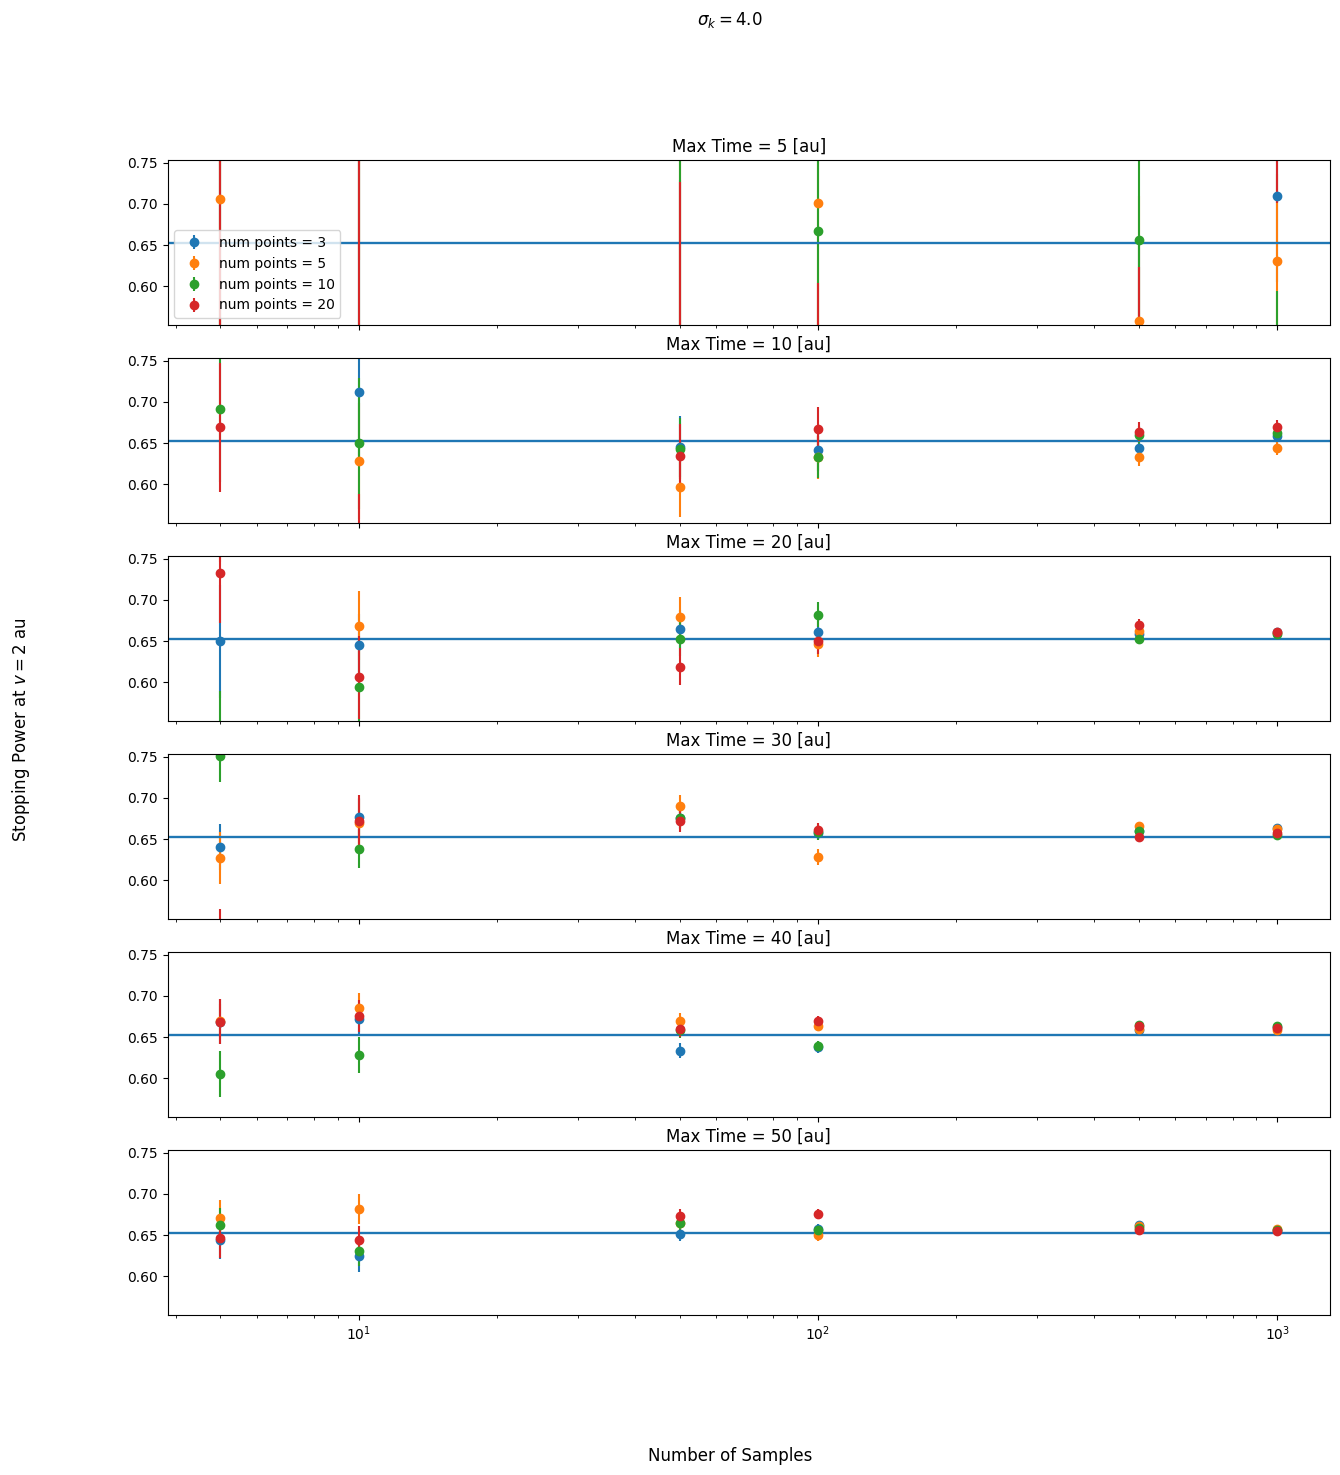

In [111]:
# Let's read in the Carbon example provided by Sandia
import numpy as np
from mec_sandia.vasp_utils import read_vasp
import matplotlib.pyplot as plt
import scipy.optimize

ase_cell = read_vasp(f"../vasp_data/C_POSCAR")
# Next we can get some system paramters
volume_ang = ase_cell.get_volume()
print("Volume = {} A^3".format(volume_ang))

# To compute rs parameter we need volume in Bohr
from ase.units import Bohr

volume_bohr = volume_ang / Bohr**3
# and the number of valence electrons
num_carbon = len(np.where(ase_cell.get_atomic_numbers() == 6)[0])
# There is 1 hydrogen atom in the cell
num_elec = 1 + num_carbon * 4
from mec_sandia.vasp_utils import compute_wigner_seitz_radius

# Get the Wigner-Seitz radius
rs = compute_wigner_seitz_radius(volume_bohr, num_elec)
print("rs = {} bohr".format(rs))
sim_res = []
act_res = []
qData2 = np.loadtxt("AndrewsFirstGaussian/C_10gpcc_1eV_stopping_config1.txt")
velocity_au = qData2[:, 0]  # the velocities are already given in atomic units

from mec_sandia.stopping_power import (
    parse_stopping_data,
    compute_stopping_power,
    _fit_linear,
)
from ase.units import Bohr, Hartree

stopping_err = 0.1  # eV/A
stopping_err_au = stopping_err * Bohr / Hartree
sigma_k = 10
# Get DFT data
qData1 = np.loadtxt("AndrewsFirstGaussian/4.0_work_vs_dist")
position_au = qData1[:, 0] / (
    0.529
)  # divide the positions (angstroms) by the number of angstroms per atomic unit
time_au = (
    position_au / 4.0
)  # divide the positions in atomic units by the velocity in atomic units to get the time in atomic units
work_au = (
    qData1[:, 1] / 27.2
)  # divide the work in eV by the number of eV per atomic unit of energy

# load the full stopping curve
qData2 = np.loadtxt("AndrewsFirstGaussian/C_10gpcc_1eV_stopping_config1.txt")
velocity_au = qData2[:, 0]  # the velocities are already given in atomic units
stopping_au = qData2[:, 1] * (
    0.529 / 27.2
)  # the stopping powers are given in eV/A, so we multiply by the number of A/bohr and divide by the number of eV/Ha
# plt.plot(velocity_au, stopping_au, marker="o", lw=0)
from scipy.interpolate import CubicSpline

stopping_spl = CubicSpline(velocity_au, stopping_au)
xs = np.linspace(velocity_au[0], velocity_au[-1], 100)
stopping_deriv_spl = stopping_spl.derivative(1)

mass_proj = 1838
ecut_ha = 2000 / Hartree
sigma_k = 4.0
box_length = volume_bohr ** (1.0 / 3.0)
print("box_length = {} bohr".format(box_length))
vel = 2.0
fig, ax = plt.subplots(6, 1, figsize=(15, 15), sharex=True)
stopping_deriv = abs(stopping_deriv_spl(vel))
num_mc_samples = [5, 10, 50, 100, 500, 1000]
for itime, max_time in enumerate([5, 10, 20, 30, 40, 50]):
    for num_pts in [3, 5, 10, 20]:
        dft_data = parse_stopping_data(
            f"AndrewsFirstGaussian/{vel}_work_vs_dist",
            vel,
            mass_proj=mass_proj,
            num_points=20,
            rare_event=0.25,
            random_sub_sample=False,
            max_time=max_time,
        )
        kproj_vals = np.array(
            [np.array([kx, 0, 0]) for kx in dft_data.kproj_sub_sample]
        )
        sim_res = []
        act_res = []
        for num_samples in num_mc_samples:
            stopping_data = compute_stopping_power(
                ecut_ha,
                box_length,
                sigma_k,
                dft_data.time_sub_sample,
                kproj_vals,
                stopping_deriv,
                mass_proj,
                num_samples=num_samples,
            )
            sim_res.append(stopping_data)
            yvals = dft_data.kproj_sub_sample**2.0 / (2 * mass_proj)
        vals = [abs(s.stopping) for s in sim_res]
        errs = [s.stopping_err for s in sim_res]
        # Plot samples along x, multiple points.
        ax[itime].axhline(stopping_spl(vel))
        ax[itime].errorbar(
            num_mc_samples,
            np.array(vals),
            yerr=errs,
            fmt="o",
            label=f"num points = {num_pts}",
        )
    ax[itime].set_title(f"Max Time = {max_time} [au]")
    ax[itime].set_ylim([stopping_spl(vel)-0.1, stopping_spl(vel)+0.1])
    ax[itime].set_xscale("log")
    if itime == 0:
        ax[0].legend()
fig.suptitle(f"$\sigma_k = {sigma_k}$")
fig.supxlabel("Number of Samples")
fig.supylabel("Stopping Power at $v=2$ au")

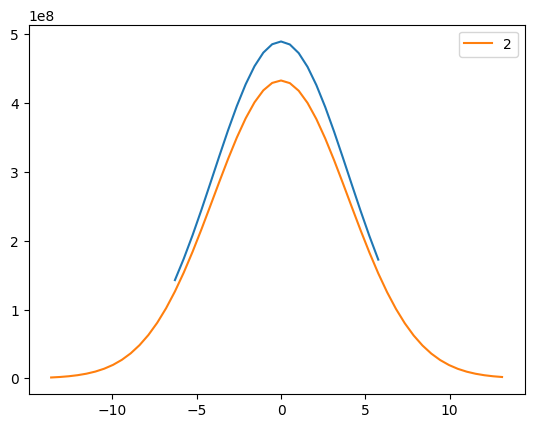

In [102]:
from mec_sandia.gaussians import _build_gaussian  
ecut_ha = 2000 / Hartree
sigma_k = 4
kproj = 3000
gaussian, kgrid = _build_gaussian(ecut_ha, box_length, sigma_k, ndim=1)
norm = np.sum(gaussian)
dk = np.array(kgrid-kproj).reshape(-1)**2.0
gaussian = (gaussian / norm).reshape(-1)
plt.plot(np.array(kgrid).reshape(-1), dk*gaussian/2*mass_proj) 
ecut_ha = 10000 / Hartree
sigma_k = 4
kproj = 3000
gaussian, kgrid = _build_gaussian(ecut_ha, box_length, sigma_k, ndim=1)
norm = np.sum(gaussian)
dk = np.array(kgrid-kproj).reshape(-1)**2.0
gaussian = (gaussian / norm).reshape(-1)
plt.plot(np.array(kgrid).reshape(-1), dk*gaussian/2*mass_proj, label="2") 
plt.legend()

# Number of samples


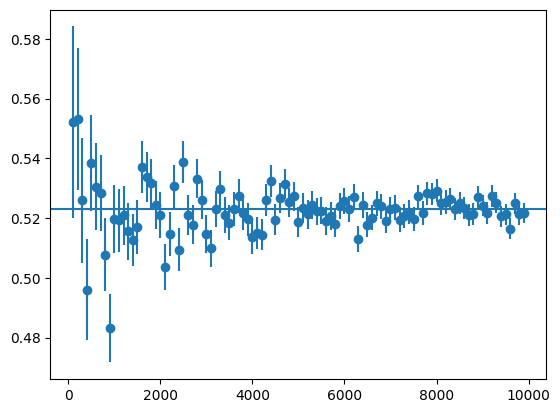

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

t_max = 40.0
sigma = 4
def func(x, a, b):
    return a*x + b

a0 = 0.523
b0 = 8000

res = []
cost = []
factor = []
num_pts = np.array(range(100, 10_000, 100))
for density in num_pts:
    xs = np.linspace(0, t_max, density)
    factor.append((t_max / density))
    cost.append(np.sum(xs))
    ys = func(xs, a0, b0) + np.random.normal(0.0, sigma, density)
    popt, pcov = scipy.optimize.curve_fit(func, xs, ys)
    res.append((popt[0], np.sqrt(pcov[0,0])))

slopes, err = zip(*res)
plt.errorbar(num_pts, slopes, yerr=err, fmt="o")
plt.axhline(a0)

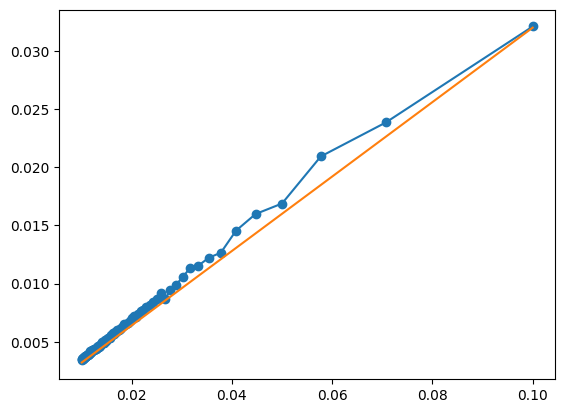

In [95]:
plt.plot(1.0/np.sqrt(num_pts), err, marker="o")
plt.plot(1.0/np.sqrt(num_pts), 0.08*sigma/np.sqrt(num_pts))

[ 100  200  300  400  500  600  700  800  900 1000 1100 1200 1300 1400
 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800
 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200
 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600
 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000
 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400
 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800
 9900]
[  2000.   4000.   6000.   8000.  10000.  12000.  14000.  16000.  18000.
  20000.  22000.  24000.  26000.  28000.  30000.  32000.  34000.  36000.
  38000.  40000.  42000.  44000.  46000.  48000.  50000.  52000.  54000.
  56000.  58000.  60000.  62000.  64000.  66000.  68000.  70000.  72000.
  74000.  76000.  78000.  80000.  82000.  84000.  86000.  88000.  90000.
  92000.  94000.  96000.  98000. 100000. 102000. 104000. 106000. 108000.
 110000. 112000. 114000. 116000. 118000. 120000. 122000. 1

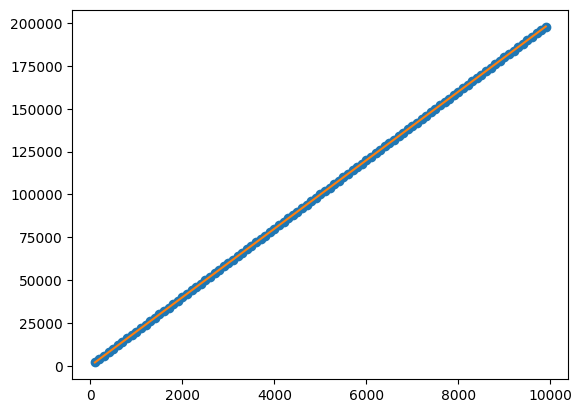

In [76]:
plt.plot(num_pts, cost, marker="o")
print(num_pts)
plt.plot(num_pts, np.array(factor)*num_pts*(num_pts+1)/2)
print(num_pts*t_max/2)

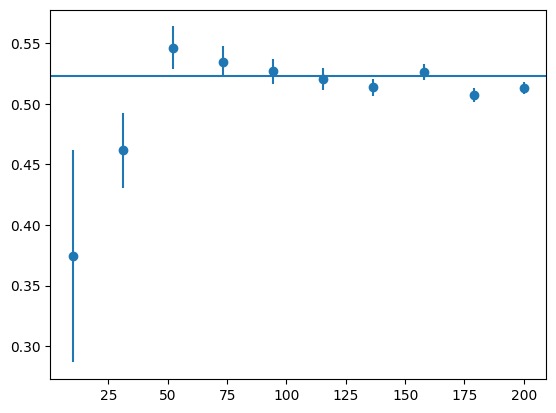

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

sigma = 4
def func(x, a, b):
    return a*x + b

a0 = 0.523
b0 = 8000

res = []
num_pts = 200
tvals = np.linspace(10, 200, 10) 
cost = []
for t_max in tvals:
    xs = np.linspace(0, t_max, num_pts)
    ys = func(xs, a0, b0) + np.random.normal(0.0, sigma, num_pts)
    cost.append(np.sum(xs))
    popt, pcov = scipy.optimize.curve_fit(func, xs, ys)
    res.append((popt[0], np.sqrt(pcov[0,0])))

slopes, err = zip(*res)
plt.errorbar(tvals, slopes, yerr=err, fmt="o")
plt.axhline(a0)

In [111]:
def linear(x, a, c):
    return a * x + c


def fit_linear(x, y):
    try:
        popt, pcov = scipy.optimize.curve_fit(linear, x, y)
        return popt
    except np.linalg.LinAlgError:
        return None
popt = fit_linear(np.log(tvals), np.log(err))
print(popt)

[-0.95150555 -0.24323132]


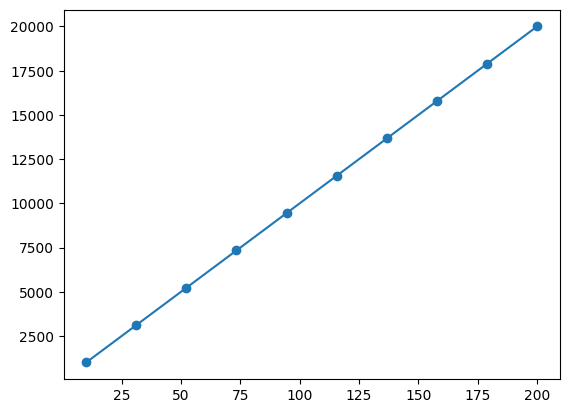

In [106]:
plt.plot(tvals, cost, marker="o")

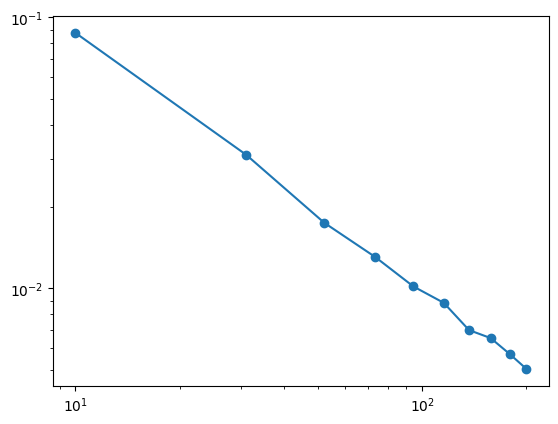

In [109]:
plt.yscale("log")
plt.xscale("log")
plt.plot(tvals, err, marker="o")